### U-net architecture for semantic segmentation

**Reference:**
Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham. [(link)](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28)

**Description:** Encoder-decoder architecture for semantic segmentation. The encoder uses pooling to reduce spatial dimensions while increasing the number of channels. The decoder uses transposed convolutions to upscale feature maps to the original resolution. Skip-connections from the encoder to the decoder help the decoder by providing local details.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

The *datasets* folder contains some helper functions to generate toy datasets.

In [2]:
from datasets.utils import generate_train_and_test_data
from datasets.segmentation.circle_segmentation import circle_segmentation_sample

Generate some synthetic training data, using the helper functions in the *dataset* module:

In [3]:
(X_train, Y_train), (X_test, Y_test) = \
    generate_train_and_test_data(circle_segmentation_sample,
                                 n_samples_train=10000, n_samples_test=1000,
                                 width=32, height=32)

The dataset consists of 32x32 images displaying a circle of a random color and size over a bunch of geometric shapes. The goal is to segment the circle:

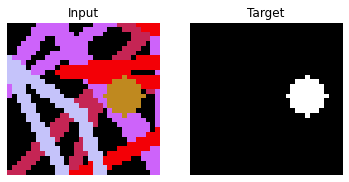

In [4]:
import matplotlib.pyplot as plt

idx = np.random.randint(X_test.shape[0])

ax = plt.subplot(121)
ax.imshow(X_test[idx,:,:])
ax.set_title("Input")
ax.axis("off")
ax = plt.subplot(122)
ax.imshow(Y_test[idx,:,:,0], cmap="gray")
ax.set_title("Target")
ax.axis("off")
plt.show()

Scale pixel values to the [0, 1] range:

In [5]:
X_train = X_train / 255
X_test = X_test / 255

The model consists of an encoder part where convolution and pooling layers are alternated to reduce the spatial dimension of the feature maps while extracting higher level features and increasing the receptive field. This encoder phase is followed by a decoder where transposed convolutions are used to upscale the feature maps to the original resolution, while the number of channels evolves towards the number of desired output channels. Skip-connections from the encoder to the decoder connect layers with a similar feature maps resolution. The skip-connected feature maps are incorporated into the decoder via feature map concatenation along the channels axis.

In [ ]:
input = keras.layers.Input((32,32,3))

conv1 = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input) 
maxp1 = keras.layers.MaxPool2D((2,2))(conv1)                                    

conv2 = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(maxp1) 
maxp2 = keras.layers.MaxPool2D((2,2))(conv2)                                     
 
conv3 = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(maxp2)
maxp3 = keras.layers.MaxPool2D((2,2))(conv3)                                     

tconv4 = keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2),                       
                                      padding="same", activation="relu")(maxp3) 
con4 = keras.layers.concatenate([tconv4, conv3], axis=3)                         

tconv5 = keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2),                       
                                      padding="same", activation="relu")(con4)  
con5 = keras.layers.concatenate([tconv5, conv2], axis=3)                      

tconv6 = keras.layers.Conv2DTranspose(32, (3,3), strides=(2,2),                       
                                      padding="same", activation="relu")(con5)  
con6 = keras.layers.concatenate([tconv6, conv1], axis=3)                      

conv7 = keras.layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(con6)

model = keras.models.Model(input, conv7)

We can visualize the model to get an idea of why this architecture is known as U-net:

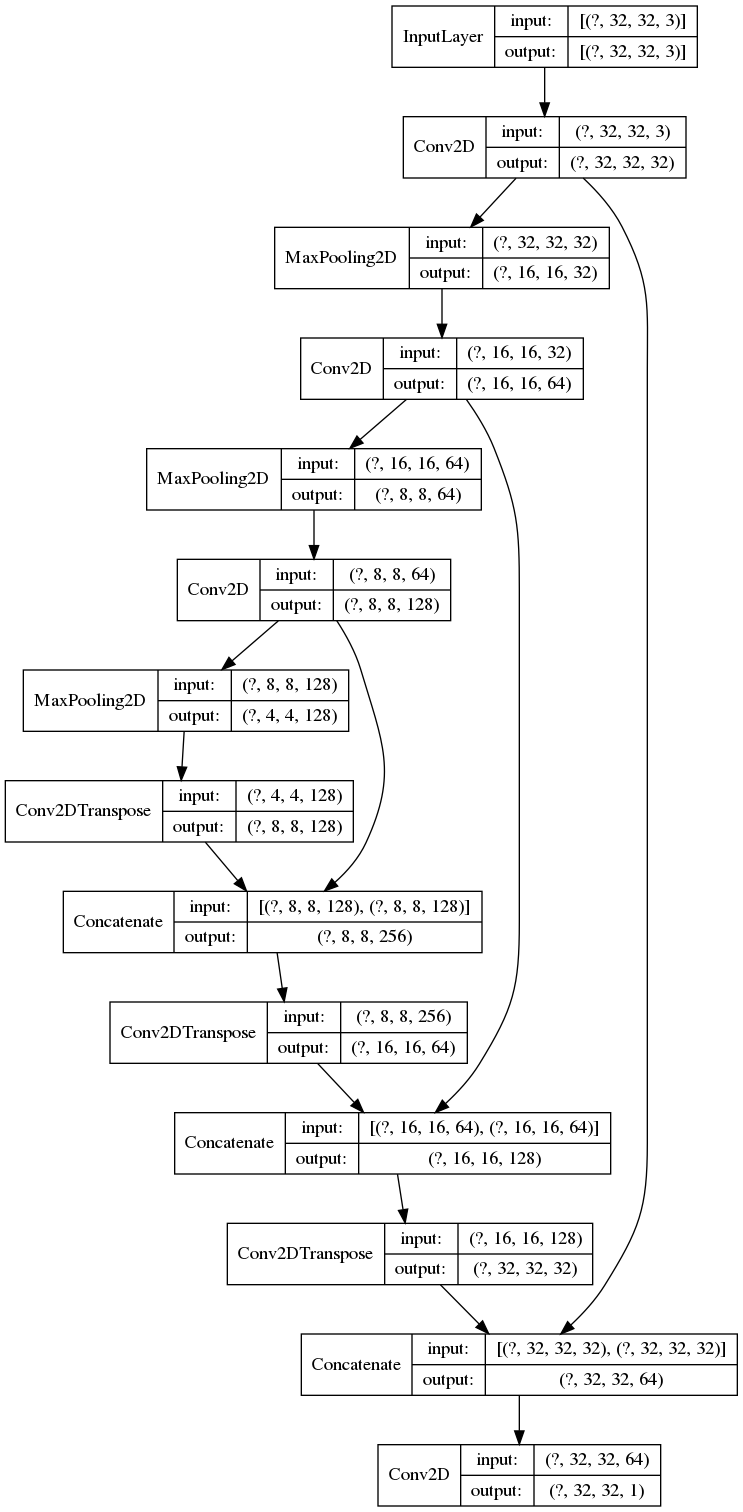

In [8]:
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

With the model defined, we proceed to train it. This should take only a few moments even on the CPU.

In [ ]:
model.compile("adam", "binary_crossentropy")

In [10]:
model.fit(X_train, Y_train, epochs=20, batch_size=64)

Train on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.2429
Epoch 2/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.1248
Epoch 3/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0786
Epoch 4/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0537
Epoch 5/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0410
Epoch 6/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0345
Epoch 7/20
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.0300
Epoch 8/20
10000/10000 [==============================] - 14s 1ms/sample - loss: 0.0263
Epoch 9/20
10000/10000 [==============================] - 17s 2ms/sample - loss: 0.0238
Epoch 10/20
10000/10000 [==============================] - 16s 2ms/sample - loss: 0.0216
Epoch 11/20
10000/10000 [==============================] - 15s 1ms/sample - loss: 0.0196
Epoch 1

After training, the model should be able to segment the circles in test images:

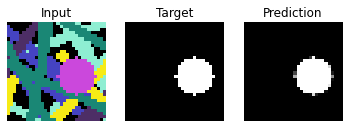

In [11]:
idx = np.random.randint(X_test.shape[0])

ax = plt.subplot(131)
ax.imshow(X_test[idx,:,:])
ax.set_title("Input")
ax.axis("off")
ax = plt.subplot(132)
ax.imshow(Y_test[idx,:,:,0], cmap="gray")
ax.set_title("Target")
ax.axis("off")
ax = plt.subplot(133)
ax.imshow(model.predict(X_test[idx:idx+1])[0,:,:,0], cmap="gray")
ax.set_title("Prediction")
ax.axis("off")
plt.show()